# Model Selection for Neural Networks

## Setup

In [35]:
import os

## adapt this directory to your needs
base_dir = '../'
notebook_dir = os.path.join(base_dir, 'Exercise')
data_dir = os.path.join(base_dir, 'DataSets')

In [36]:
import random

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score

import tensorflow as tf

from pyMLaux import show_img_data, evaluate_classification_result

## Load Simple Digit Recognition Data

In [37]:
dig_train_raw = pd.read_csv(os.path.join(data_dir,'Digits_training.csv'), sep=',')
dig_train = {'data': np.array(dig_train_raw.iloc[:, :-1]),
             'target': np.array(dig_train_raw.iloc[:, -1]),
             'feature_names': dig_train_raw.columns[:-1],
             'target_names': [str(i) for i in range(0, 10)]}

In [38]:
dig_test_raw = pd.read_csv(os.path.join(data_dir, 'Digits_test.csv'), sep=',')
dig_test = {'data': np.array(dig_test_raw.iloc[:, :-1]),
            'target': np.array(dig_test_raw.iloc[:, -1]),
            'feature_names': dig_test_raw.columns[:-1],
            'target_names': [str(i) for i in range(0, 10)]}

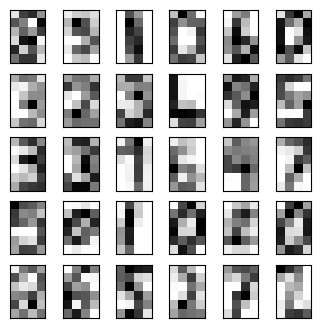

In [39]:
show_img_data(dig_train['data'].reshape((dig_train['data'].shape[0], 6, 4, 1)), figsize=(4, 4),
              interpolation=None)

In [40]:
dig_train['target'][range(0, 30)].reshape(5, 6)

array([[8, 5, 1, 0, 6, 0],
       [3, 2, 3, 4, 9, 5],
       [3, 3, 1, 6, 4, 7],
       [5, 0, 1, 0, 2, 0],
       [2, 6, 5, 2, 7, 2]])

In [41]:
X_train, X_val, y_train, y_val = train_test_split(dig_train['data'], dig_train['target'],
                                                  test_size=0.3, random_state=4232)

## Functions for Hyperparameter/Architecture Selection

In [42]:
def create_hyperparams(n, default_lr=0.001):
    df = pd.DataFrame(index=range(n),
                      columns=['no_hidden_layers', 'hidden_layers', 'activation', 'dropout', 'lr', 'epochs'])

    for i in range(n):
        df.loc[i, 'lr'] = default_lr * 5.**random.uniform(-1., 1.)
        df.loc[i, 'epochs'] = random.sample([64, 128, 256], 1)[0] # Removed 16 and 32 epochs ==> too few epochs. Also added 256

        no_layers = random.randint(2, 6) # Zero and 1 hidden layers make no sense. Also increase to 6 hidden layers instead of 4
        df.loc[i, 'no_hidden_layers'] = no_layers
        df.loc[i, 'hidden_layers'] = [int(random.sample([32, 64, 128, 256, 512], 1)[0]) for i in range(no_layers)] # Removed 8 and 16 neurons ==> too few neurons. Also added 128, 256 and 512
        df.loc[i, 'dropout'] = random.sample([0.2, 0.3, 0.4, 0.5], 1)[0] # Removed 0 dropout, because it is not recommended for deep networks
        df.loc[i, 'activation'] = random.sample(['relu', 'elu'], 1)[0] # Removed sigmoid, because it does not train well for deep networks

    return(df)

In [43]:
def create_network(hp, no_inputs, no_outputs, output_activation='softmax', **kwargs):
    hidden_layers = hp['hidden_layers']

    dropout = hp['dropout']
    hidden_activation = hp['activation']

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(no_inputs, )))

    for cl in hidden_layers:
        model.add(tf.keras.layers.Dense(cl, activation=hidden_activation))
        if dropout > 0:
            model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Dense(no_outputs, activation=output_activation))

    opt = tf.keras.optimizers.Adam(learning_rate=hp['lr'])

    model.compile(optimizer=opt, **kwargs)

    return(model)

In [ ]:
df = create_hyperparams(100000) # Create 100000 hyperparameters to search through
df

,no_hidden_layers,hidden_layers,activation,dropout,lr,epochs
0,6,"[512, 512, 128, 256, 512, 512]",relu,0.3,0.001206,64
1,6,"[32, 256, 256, 256, 128, 128]",elu,0.3,0.004129,256
2,3,"[64, 64, 256]",elu,0.2,0.001042,256
3,6,"[32, 128, 128, 64, 512, 256]",relu,0.2,0.000629,128
4,6,"[512, 32, 32, 32, 128, 128]",relu,0.3,0.000205,64
...,...,...,...,...,...,...
2995,3,"[256, 64, 512]",elu,0.3,0.001433,128
2996,6,"[512, 512, 64, 64, 128, 512]",elu,0.2,0.000216,64
2997,6,"[64, 32, 256, 128, 64, 256]",relu,0.5,0.000721,64
2998,3,"[512, 32, 32]",elu,0.5,0.001211,128


In [45]:
model = create_network(df.iloc[1, :], no_inputs=24, no_outputs=10, loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,530 (748.16 KB)

 Trainable params: 191,530 (748.16 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
def find_best(df, crit='ACC'):
    index = np.where(df[crit] == np.amax(df[crit]))[0]
    return(df.iloc[list(index), :])

## Perform Model Selection and Determine Best Model

In [48]:
random.seed(4232)
batch_size = 32
no_models = 25

In [49]:
model_sel = create_hyperparams(no_models)
model_sel['ACC'] = -1.

In [50]:
model_sel

,no_hidden_layers,hidden_layers,activation,dropout,lr,epochs,ACC
0,5,"[64, 64, 32, 256, 32]",elu,0.2,0.000845,128,-1.0
1,2,"[512, 256]",elu,0.5,0.00256,64,-1.0
2,6,"[256, 256, 32, 32, 256, 128]",relu,0.5,0.000638,128,-1.0
3,4,"[256, 512, 32, 512]",relu,0.3,0.001695,256,-1.0
4,3,"[32, 512, 128]",elu,0.4,0.00191,256,-1.0
5,6,"[256, 256, 64, 128, 32, 256]",elu,0.2,0.001705,256,-1.0
6,4,"[128, 64, 128, 128]",elu,0.5,0.004138,256,-1.0
7,5,"[128, 64, 256, 32, 512]",relu,0.5,0.000233,64,-1.0
8,4,"[256, 32, 256, 256]",relu,0.5,0.000447,64,-1.0
9,6,"[128, 128, 64, 128, 64, 512]",elu,0.3,0.000794,64,-1.0


In [51]:
pbar = tf.keras.utils.Progbar(target=no_models, stateful_metrics=[]) ## progress bar
for i in range(no_models):
    model = create_network(model_sel.iloc[i], no_inputs=X_train.shape[1],
                           no_outputs=10, loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

    history = model.fit(x=X_train, y=y_train,
                        epochs=model_sel['epochs'][i],
                        batch_size=batch_size,
                        verbose=0)

    pred = model.predict(x=X_val, verbose=0)
    predC = np.argmax(pred, axis=1)

    model_sel.loc[i, 'ACC'] = accuracy_score(y_val, predC)

    tf.keras.backend.clear_session()
    pbar.update(i, finalize=False)
pbar.update(no_models, finalize=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 910s 36s/step


In [52]:
model_sel.sort_values(by='ACC', ascending=False).head(10)

,no_hidden_layers,hidden_layers,activation,dropout,lr,epochs,ACC
11,2,"[128, 512]",relu,0.3,0.000385,256,0.953333
20,2,"[256, 512]",relu,0.2,0.00197,64,0.952222
16,6,"[256, 512, 32, 128, 32, 64]",elu,0.2,0.000328,256,0.946667
13,6,"[256, 512, 256, 128, 256, 64]",relu,0.2,0.002647,64,0.944444
3,4,"[256, 512, 32, 512]",relu,0.3,0.001695,256,0.944444
5,6,"[256, 256, 64, 128, 32, 256]",elu,0.2,0.001705,256,0.943333
1,2,"[512, 256]",elu,0.5,0.00256,64,0.941111
18,4,"[128, 512, 512, 256]",elu,0.4,0.000996,256,0.941111
21,5,"[64, 128, 128, 128, 64]",relu,0.3,0.000465,128,0.938889
15,4,"[64, 256, 32, 64]",relu,0.4,0.001645,128,0.938889


In [53]:
find_best(model_sel)

,no_hidden_layers,hidden_layers,activation,dropout,lr,epochs,ACC
11,2,"[128, 512]",relu,0.3,0.000385,256,0.953333


In [54]:
best_index = find_best(model_sel).index[0]

## Train Model on Entire Training Set Using Best Parameters


In [55]:
model = create_network(model_sel.loc[best_index], no_inputs=X_train.shape[1],
                       no_outputs=10, loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,378 (290.54 KB)

 Trainable params: 74,378 (290.54 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
history = model.fit(x=dig_train['data'], y=dig_train['target'],
                    epochs=model_sel.loc[best_index, 'epochs'],
                    batch_size=batch_size)

Epoch 1/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2166 - loss: 2.2031
Epoch 2/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6236 - loss: 1.4369
Epoch 3/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7286 - loss: 0.9463
Epoch 4/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7797 - loss: 0.7794
Epoch 5/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7752 - loss: 0.7152
Epoch 6/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8003 - loss: 0.6369
Epoch 7/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8231 - loss: 0.5984
Epoch 8/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8383 - loss: 0.5370
Epoch 9/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8437 - loss: 0.5212
Epoch 10/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8466 - loss: 0.5242
Epoch 11/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8639 - loss: 0.4470
Epoch 12/256
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

## Test Model on Test Data

In [58]:
pred = model.predict(dig_test['data'])

evaluate_classification_result(dig_test['target'], pred, classes=dig_test['target_names'])

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion matrix (rows -> true, columns -> predicted):

     0    1    2    3    4    5    6    7    8    9
0  208    2    0    0    0    0    1    1    0    0
1    0  196    2    0    1    0    0    1    0    3
2    0    2  183    0    1    0    0    0    0    0
3    2    0    2  182    1    5    0    1    1    8
4    0    1    0    0  202    0    3    0    0    2
5    1    0    0    1    0  181    4    0    0    3
6    2    2    0    0    2    1  197    0    0    0
7    0    2    5    1    0    0    0  190    1    3
8    1    2    0    4    3    2    1    1  179    0
9    1    0    1    2    1    2    0    0    1  196


Class 0:
    Sensitivity (TPR):  98.113% (208 of 212)
    Specificity (TNR):  99.609% (1785 of 1792)
    Precision:          96.744% (208 of 215)
    Neg. pred. value:   99.776% (1785 of 1789)
Class 1:
    Sensitivity (TPR):  96.552% (196 of 203)
    Specificity (TNR):  99.389% (1790 of 1801)
    Precision:          94.686% (196 

In [59]:
!jupyter nbconvert --to html Ex3_Grimm.ipynb

[NbConvertApp] Converting notebook Ex3_Grimm.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 378696 bytes to Ex3_Grimm.html
